# Develop, evaluate, and score a forecasting model for superstore sales

## Introduction

In this notebook, you'll see Microsoft Fabric's end-to-end data science workflow for a forecasting model. This scenario uses the historic sales data to predict the sales for different categories of products at a superstore.

Forecasting is a crucial asset in sales, harnessing historical data and predictive methods to provide insights into future trends. By analyzing past sales, identifying patterns, and learning from consumer behavior, businesses can optimize inventory, production, and marketing strategies. This proactive approach enhances adaptability, responsiveness, and overall performance of businesses in a dynamic marketplace.

The main steps in this notebook are:

1. Load the data
2. Understand and process the data using exploratory data analysis
3. Train a machine learning model using an open source software package called `SARIMAX` and track experiments using MLflow and Fabric Autologging feature
4. Save the final machine learning model and make predictions
5. Demonstrate the model performance via visualizations in Power BI


## Prerequisites
- [Add a lakehouse](https://aka.ms/fabric/addlakehouse) to this notebook. You will be downloading data from a public blob, then storing the data in the lakehouse. 

## Step 1: Load the Data


### Dataset

The dataset contains the sales of different products, along with 21 attributes that include: `Row ID`, `Order ID`, `Order Date`, `Ship Date`, `Ship Mode`, `Customer ID`, `Customer Name`, `Segment`, `Country`, `City`, `State`, `Postal Code`, `Region`, `Product ID`, `Category`, `Sub-Category`, `Product Name`, `Sales`, `Quantity`, `Discount`, `Profit`.

- Superstore.xlsx

|"Row ID|"Order ID"|"Order Date"|"Ship Date"|"Ship Mode"|"Customer ID"|"Customer Name"|"Segment"|"Country"|"City"|"State"|"Postal Code"|"Region"|"Product ID"|"Category"|"Sub-Category"|"Product Name"|"Sales"|"Quantity"|"Discount"|"Profit"|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|4|US-2015-108966|2015-10-11|2015-10-18|Standard Class|SO-20335|Sean O'Donnell|Consumer|United States|Fort Lauderdale|Florida|33311|South|FUR-TA-10000577|Furniture|Tables|Bretford CR4500 Series Slim Rectangular Table|957.5775|5|0.45|-383.0310|
|11|CA-2014-115812|2014-06-09|2014-06-09|Standard Class|Standard Class|Brosina Hoffman|Consumer|United States|Los Angeles|California|90032|West|FUR-TA-10001539|Furniture|Tables|Chromcraft Rectangular Conference Tables|1706.184|9|0.2|85.3092|
|31|US-2015-150630|2015-09-17|2015-09-21|Standard Class|TB-21520|Tracy Blumstein|Consumer|United States|Philadelphia|Pennsylvania|19140|East|OFF-EN-10001509|Office Supplies|Envelopes|Poly String Tie Envelopes|3.264|2|0.2|1.1016



> [!TIP]
> By defining the following parameters, you can apply this notebook on different datasets easily.


In [19]:
IS_CUSTOM_DATA = False  # if TRUE, dataset has to be uploaded manually

IS_SAMPLE = True  # if TRUE, use only rows of data for training, otherwise use all data
SAMPLE_ROWS = 5000  # if IS_SAMPLE is True, use only this number of rows for training

DATA_ROOT = "/lakehouse/default"
DATA_FOLDER = "Files/salesforecast"  # folder with data files
DATA_FILE = "Superstore.xlsx"  # data file name

EXPERIMENT_NAME = "aisample-superstore-forecast"  # MLflow experiment name

StatementMeta(, 3a9544bf-f59e-4bed-a464-8000a430f5d3, 21, Finished, Available, Finished)

### Download the dataset and Upload to the lakehouse

The following code will download a publicly available version of the the dataset and then store it in a Fabric lakehouse.

> [!IMPORTANT]
> **Make sure you [add a lakehouse](https://aka.ms/fabric/addlakehouse) to the notebook before running it. Failure to do so will result in an error.**

In [20]:
import os, requests
if not IS_CUSTOM_DATA:
    # Download data files into lakehouse if not already there
    remote_url = "https://synapseaisolutionsa.blob.core.windows.net/public/Forecast_Superstore_Sales"
    file_list = ["Superstore.xlsx"]
    download_path = "/lakehouse/default/Files/salesforecast/raw"

    if not os.path.exists("/lakehouse/default"):
        raise FileNotFoundError(
            "Default lakehouse not found, please add a lakehouse and restart the session."
        )
    os.makedirs(download_path, exist_ok=True)
    for fname in file_list:
        if not os.path.exists(f"{download_path}/{fname}"):
            r = requests.get(f"{remote_url}/{fname}", timeout=30)
            with open(f"{download_path}/{fname}", "wb") as f:
                f.write(r.content)
    print("Downloaded demo data files into lakehouse.")

StatementMeta(, 3a9544bf-f59e-4bed-a464-8000a430f5d3, 22, Finished, Available, Finished)

Downloaded demo data files into lakehouse.


Start recording the time it takes to run this notebook.

In [21]:
# Record the notebook running time
import time

ts = time.time()

StatementMeta(, 3a9544bf-f59e-4bed-a464-8000a430f5d3, 23, Finished, Available, Finished)

### Set up the MLflow experiment tracking

Autologging in Microsoft Fabric extends the MLflow autologging capabilities by automatically capturing the values of input parameters and output metrics of a machine learning model as it is being trained. This information is then logged to the workspace, where it can be accessed and visualized using the MLflow APIs or the corresponding experiment in the workspace. To learn more about autologging, see [Autologging in Microsoft Fabric](https://aka.ms/fabric-autologging).

In [22]:
# Set up MLflow for experiment tracking
import mlflow

mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.autolog(disable=True)  # Disable MLflow autologging

StatementMeta(, 3a9544bf-f59e-4bed-a464-8000a430f5d3, 24, Finished, Available, Finished)

> [!NOTE]
> If you want to disable Microsoft Fabric autologging in a notebook session, call `mlflow.autolog()` and set `disable=True`.

### Read raw data from the lakehouse

Read raw data from the **Files** section of the lakehouse. Add additional columns for different date parts and the same information will be used to create partitioned delta table. Since the raw date is stored as an Excel file, you need to use Pandas to read the raw data.

In [23]:
import pandas as pd
df = pd.read_excel("/lakehouse/default/Files/salesforecast/raw/Superstore.xlsx")

StatementMeta(, 3a9544bf-f59e-4bed-a464-8000a430f5d3, 25, Finished, Available, Finished)

## Step 2: Exploratory Data Analysis

### Import libraries

Prior to any analysis, you need to import the required libraries.

In [24]:
# Importing required libraries
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

StatementMeta(, 3a9544bf-f59e-4bed-a464-8000a430f5d3, 26, Finished, Available, Finished)

### Display the raw data

To review the dataset, it is recommended to manually go through a subset of the data to gain a better understanding. In this regard, you could use the `display` function to print the DataFrame. You can also show the "Chart" views to easily visualize subsets of the dataset.

In [25]:
display(df)

StatementMeta(, 3a9544bf-f59e-4bed-a464-8000a430f5d3, 27, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, f7131a7a-74b4-43ae-8582-7e04764af128)

Note that in this notebook, the primary focus will be on forecasting the sales for the `Furniture` category. This choice is made to speed up the computation and facilitate the demonstration of the model's performance. However, it is important to realize that this techniques used in this notebook are adaptable and can be extended to predict the sales of various other product categories.

In [26]:
# Select "Furniture" as the product category
furniture = df.loc[df['Category'] == 'Furniture']
print(furniture['Order Date'].min(), furniture['Order Date'].max())

StatementMeta(, 3a9544bf-f59e-4bed-a464-8000a430f5d3, 28, Finished, Available, Finished)

2014-01-06 00:00:00 2017-12-30 00:00:00


### Pre-processing the data

In real-world business scenarios, when forecasting the sales there is often a need to predict sales in three distinct categories:

- Forecast sales for a specific category of customers
- Forecast sales for a specific product category and customer combination
- Forecast overall sales for a specific product category

In this notebook, your focus will be on forecasting overall sales for a specific product category. First, perform some pre-processing on the data by dropping unnecessary columns that include `Row ID`, `Order ID`, `Ship Date`, `Ship Mode`, `Customer ID`, `Customer Name`, `Segment`, `Country`, `City`, `State`, `Postal Code`, `Region`, `Product ID`, `Category`, `Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit`. 

Some of the columns such as `Row ID`, `Order ID`,`Customer ID`, `Customer Name` have no impact and you can drop them. Moreover, since the focus is to forecast the overall sales for the `Funiture` category across the state and region, you can also drop columns such as `State`, `Region`, `Country`, `City`, `Postal Code`. If you require to forecast the sales for a specific location or category, you may require to adjust the pre-processing step accordingly.


In [27]:
# Data preprocessing
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 
'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 
'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
# Drop unnecessary columns
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

StatementMeta(, 3a9544bf-f59e-4bed-a464-8000a430f5d3, 29, Finished, Available, Finished)

Order Date    0
Sales         0
dtype: int64

The dataset is structured on a daily basis, and since the goal is to develop a model to forecast the sales on a monthly basis, you need to resample on the column `Order Date`.

First, group the `Furniture` category by `Order Date` and then calculate the sum of the `Sales` column for each group in order to determine the total sales for each unique `Order Date`. Then, resample the `Sales` column using the `MS` frequency to aggregate the data by month and then you calculate the mean sales value for each month.

In [28]:
# Data Preparation
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
furniture.index
y = furniture['Sales'].resample('MS').mean()
y = y.reset_index()
y['Order Date'] = pd.to_datetime(y['Order Date'])
y['Order Date'] = [i+pd.DateOffset(months=67) for i in y['Order Date']]
y = y.set_index(['Order Date'])
maximim_date = y.reset_index()['Order Date'].max()

StatementMeta(, 3a9544bf-f59e-4bed-a464-8000a430f5d3, 30, Finished, Available, Finished)

Demonstrate the impact of `Order Date` on the `Sales` for the Furniture category.

StatementMeta(, 3a9544bf-f59e-4bed-a464-8000a430f5d3, 31, Finished, Available, Finished)

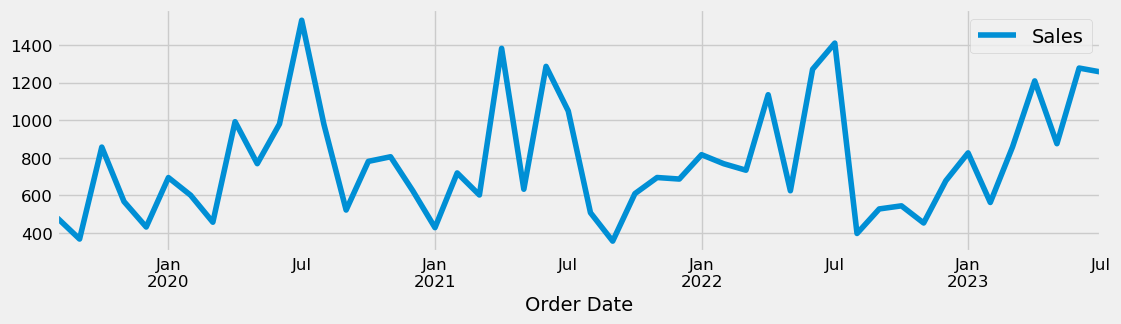

In [29]:
# Impact of order date on the sales
y.plot(figsize=(12, 3))
plt.show()

Prior to any statistical analysis, you need to import `statsmodels`. `Statsmodels` is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests and statistical data exploration.

In [30]:
import statsmodels.api as sm

StatementMeta(, 3a9544bf-f59e-4bed-a464-8000a430f5d3, 32, Finished, Available, Finished)

### Statistical analysis

A time series tracks four data elements at set intervals in order to determine the variation of those four elements in the time series pattern. These elements include:

- **Level:** Refers to the fundamental component that represents the average value for a specific time period.

- **Trend:** Describes whether the time series is decreasing, constant, or increasing over time.

- **Seasonality:** Describes the periodic signal in the time series and looks for cyclic occurrences that affect the time series' increasing or decreasing patterns.

- **Noise/Residual:** Refers to the random fluctuations and variability in the time series data that cannot be explained by the model.

In the following, you will observe the above four components for your dataset after the pre-processing.


StatementMeta(, 3a9544bf-f59e-4bed-a464-8000a430f5d3, 33, Finished, Available, Finished)

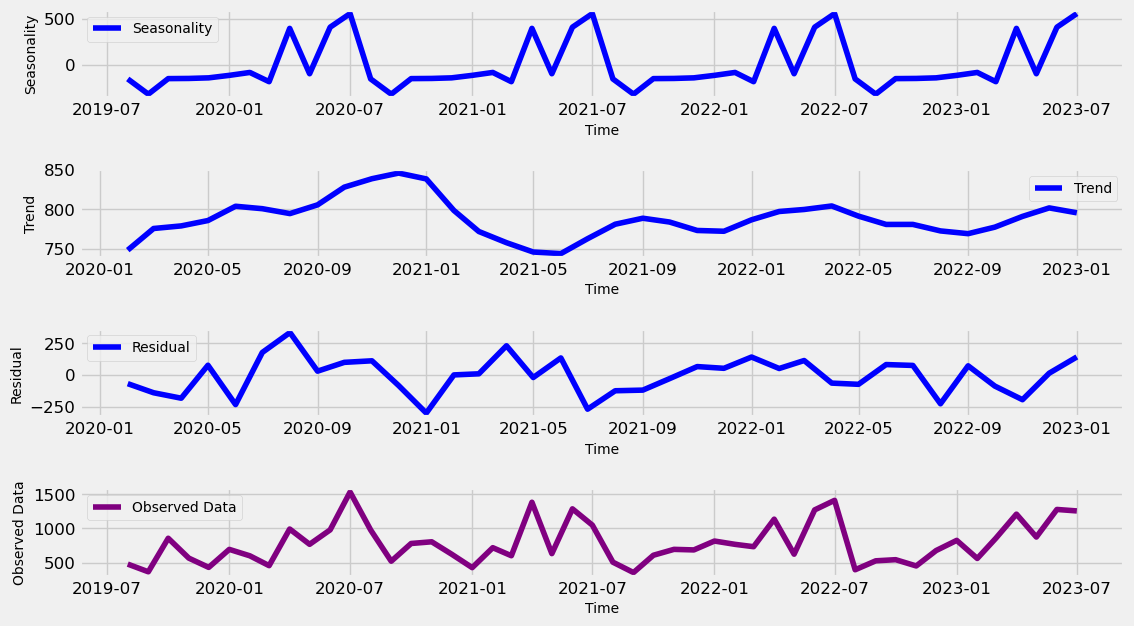

In [31]:
# Decompose the time series into its components using statsmodels
result = sm.tsa.seasonal_decompose(y, model='additive')

# Labels and corresponding data for plotting
components = [('Seasonality', result.seasonal),
              ('Trend', result.trend),
              ('Residual', result.resid),
              ('Observed Data', y)]

# Create subplots in a grid
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 7))
plt.subplots_adjust(hspace=0.8)  # Adjust vertical space
axes = axes.ravel()

# Plot the components
for ax, (label, data) in zip(axes, components):
    ax.plot(data, label=label, color='blue' if label != 'Observed Data' else 'purple')
    ax.set_xlabel('Time')
    ax.set_ylabel(label)
    ax.set_xlabel('Time', fontsize=10)
    ax.set_ylabel(label, fontsize=10)
    ax.legend(fontsize=10)

plt.show()

Understanding the seasonality, trend, and noise in the forecasting data through the above plots allows to capture underlying patterns, and develop models that make more accurate predictions that are resilient to random fluctuations.

## Step 3: Model Training and Tracking

With your data in place, you can define the forecasting model. Apply the Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors (SARIMAX) in this notebook. SARIMAX is a time series forecasting model that extends SARIMA to include exogenous variables. It combines autoregressive (AR) and moving average (MA) components, seasonal differencing, and external predictors to make accurate and flexible forecasts for time series data, making it a powerful tool for various forecasting tasks.

You will also use MLfLow and Fabric Autologging to track the experiments. Here you'll load the delta table from the lakehouse. You may use other delta tables considering the lakehouse as the source.

In [32]:
# Import required libraries for model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

StatementMeta(, 3a9544bf-f59e-4bed-a464-8000a430f5d3, 34, Finished, Available, Finished)

### Hyperparameter tuning

SARIMAX takes into account the parameters involved in regular ARIMA mode `(p,d,q)` and also adds the seasonality parameters `(P,D,Q,s)`. These arguments to SARIMAX model are called order `(p,d,q)` and seasonal order `(P,D,Q,s)` respectively and hence 7 parameters to tune. Prior to model training, you need to set up these parameters which are defined in the following.

#### Order Parameters `(p, d, q)`:
- `p`: The order of the autoregressive (AR) component, indicating how many past observations are considered. It is also known as the AR order.
- `d`: The degree of differencing required to make the time series stationary. It is also known as the differencing order.
- `q`: The order of the moving average (MA) component, indicating how many past white noise error terms are considered. It is also known as the MA order.

#### Seasonal Order Parameters `(P, D, Q, s)`:

- `P`: The seasonal order of the autoregressive (AR) component, similar to `p` but for the seasonal part.
- `D`: The seasonal order of differencing, similar to `d` but for the seasonal part.
- `Q`: The seasonal order of the moving average (MA) component, similar to `q` but for the seasonal part.
- `s`: The number of time steps per seasonal cycle (e.g., 12 for monthly data with a yearly seasonality).

In [33]:
# Hyperparameters tuning
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

StatementMeta(, 3a9544bf-f59e-4bed-a464-8000a430f5d3, 35, Finished, Available, Finished)

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


- The autoregressive order `p` represents the number of past observations in the time series that are used to predict the current value. Typically, `p` should be a non-negative integer. Common values for `p` are usually in the range of 0 to 3, although higher values are possible depending on the specific characteristics of the data. A higher p indicates a longer memory of past values in the model.

- The moving average order `q` represents the number of past white noise error terms that are used to predict the current value. Similar to `p`, `q` should also be a non-negative integer. Common values for `q` are typically in the range of 0 to 3, but higher values may be necessary for certain time series. A higher `q` indicates a stronger reliance on past error terms to make predictions.

- The differencing order `d` represents the number of times the time series needs to be differenced to achieve stationarity. `d` should be a non-negative integer. Common values for `d` are usually in the range of 0 to 2. A `d` value of 0 means the time series is already stationary, while higher values indicate the number of differencing operations required to make it stationary.

- The `enforce_stationarity` parameter controls whether or not the model should enforce stationarity on the time series data before fitting the SARIMAX model. When `enforce_stationarity` is set to `True` (the default), it indicates that the SARIMAX model should enforce stationarity on the time series data. This means that the SARIMAX model will automatically apply differencing to the data to make it stationary, as specified by the `d` and `D` orders, before fitting the model. This is a common practice because many time series models, including SARIMAX, assume that the data is stationary. If your time series is non-stationary (e.g., it exhibits trends or seasonality), it is generally a good practice to set `enforce_stationarity` to `True` and let the SARIMAX model handle the differencing to achieve stationarity. If your time series is already stationary (e.g., it has no trends or seasonality), you can set `enforce_stationarity` to `False` to avoid unnecessary differencing.

- The `enforce_invertibility` parameter controls whether or not the model should enforce invertibility on the estimated parameters during the optimization process. When `enforce_invertibility` is set to `True` (the default), it indicates that the SARIMAX model should enforce invertibility on the estimated parameters. Invertibility ensures that the model is well-defined and that the estimated autoregressive (AR) and moving average (MA) coefficients are within the range of stationarity. Enforcing invertibility is typically recommended to ensure that the SARIMAX model adheres to the theoretical requirements for a stable time series model and helps prevent issues with model estimation and stability.

- The default is an `AR(1)` model which refers to `(1,0,0)`. However, keep in mind that the appropriate values for `p`, `q`, and `d` can vary from one time series to another, and determining the optimal values often involves analyzing the autocorrelation and partial autocorrelation functions (ACF and PACF) of the time series data and using model selection criteria like AIC or BIC. It's common practice to try different combinations of p, q, and d and evaluate the model's performance for a given dataset. Note that the parameters for the seasonal order `(P, D, Q, s)` is similar in concept to the non-seasonal order parameters `(p, q, d)`, hence it is avoided explaining in detail again. 

In [34]:
# Tune the hyperparameters to determine the best model
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit(disp=False)
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

StatementMeta(, 3a9544bf-f59e-4bed-a464-8000a430f5d3, 36, Finished, Available, Finished)

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1510.8582301117497
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.7170130919809
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.27028997935594
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418338
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1045.3942480494427
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.24882803010433
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758113
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2681.065204158917
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.56074298091625
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.6261389673298
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.5852417277453
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2347.3441980299103
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.9884876946868
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.87255765183426
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.8947668414504
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1443.94687899968
ARIM

Upon evaluation of the above results, you can determine the values for both the order parameters and then seasonal order parameters. The choice is `order=(0, 1, 1)` and `seasonal_order=(0, 1, 1, 12)` which offers the lowest AIC (e.g., 279.58) and hence are used to train the model in the following.

#### Model training



In [35]:
# Model Training 
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit(disp=False)
print(results.summary().tables[1])

StatementMeta(, 3a9544bf-f59e-4bed-a464-8000a430f5d3, 37, Finished, Available, Finished)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000   4115.190     -0.000      1.000   -8066.623    8064.623
ma.S.L12      -3.2470      1.670     -1.944      0.052      -6.520       0.026
sigma2      2368.6716   9.75e+06      0.000      1.000   -1.91e+07    1.91e+07


In the following, you visualize a time series forecast for furniture sales data, showing both the observed data and the one-step-ahead forecast with a confidence interval shaded region. 

StatementMeta(, 3a9544bf-f59e-4bed-a464-8000a430f5d3, 38, Finished, Available, Finished)

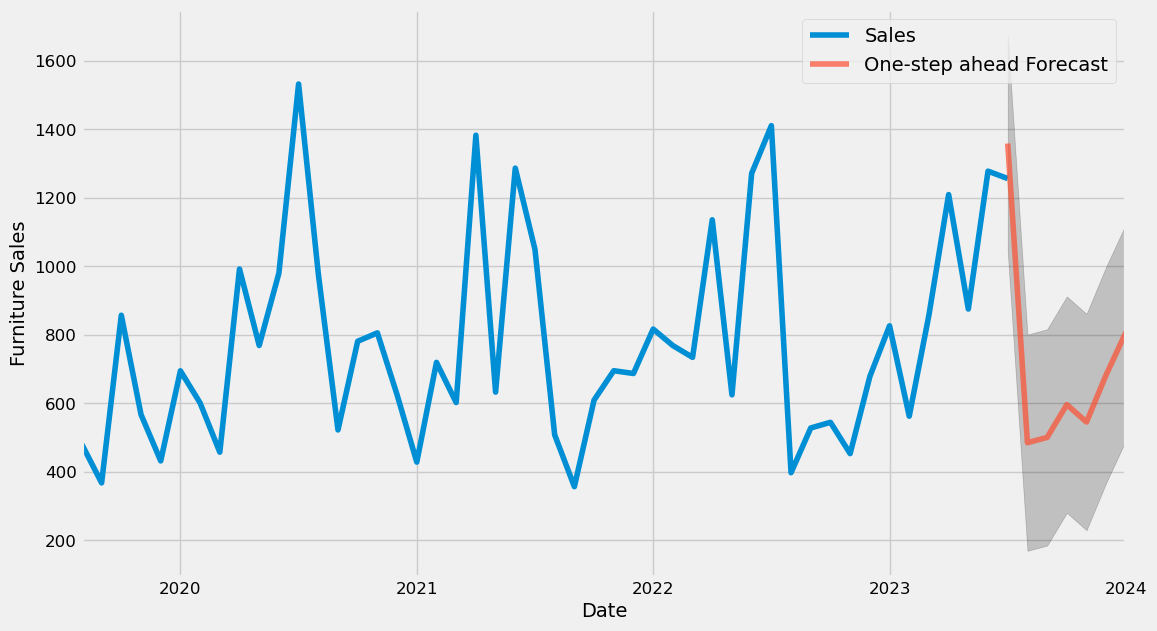

In [36]:
# Plot the forecasting results
pred = results.get_prediction(start=maximim_date, end=maximim_date+pd.DateOffset(months=6), dynamic=False) # Forecast for the next 6 months (months=6)
pred_ci = pred.conf_int() # Extract the confidence intervals for the predictions.
ax = y['2019':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(12, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [37]:
# Validate the forecasted result
predictions = results.get_prediction(start=maximim_date-pd.DateOffset(months=6-1), dynamic=False)
# Forecast on the unseen future data
predictions_future = results.get_prediction(start=maximim_date+ pd.DateOffset(months=1),end=maximim_date+ pd.DateOffset(months=6),dynamic=False)

StatementMeta(, 3a9544bf-f59e-4bed-a464-8000a430f5d3, 39, Finished, Available, Finished)

Note that `predictions` is utilized to assess the model's performance by contrasting it with the actual values, whereas `predictions_future` is indicative of future forecasting.

#### Experiments artifact for tracking model performance

Extending the MLflow autologging capabilities, autologging works by automatically capturing the values of input parameters and output metrics of a machine learning model as it is being trained. This information is then logged to your workspace, where it can be accessed and visualized using the MLflow APIs or the corresponding experiment in your workspace. To learn more about autologging, see [Autologging in Microsoft Fabric](https://aka.ms/fabric-autologging).


In [38]:
# Log the model and parameters
model_name = f"{EXPERIMENT_NAME}-Sarimax"
with mlflow.start_run(run_name="Sarimax") as run:
    mlflow.statsmodels.log_model(results,model_name,registered_model_name=model_name)
    mlflow.log_params({"order":(0,1,1),"seasonal_order":(0, 1, 1, 12),'enforce_stationarity':False,'enforce_invertibility':False})
    model_uri = f"runs:/{run.info.run_id}/{model_name}"
    print("Model saved in run %s" % run.info.run_id)
    print(f"Model URI: {model_uri}")
mlflow.end_run()

StatementMeta(, 3a9544bf-f59e-4bed-a464-8000a430f5d3, 40, Finished, Available, Finished)

Successfully registered model 'aisample-superstore-forecast-Sarimax'.
2024/07/21 13:18:38 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: aisample-superstore-forecast-Sarimax, version 1
Created version '1' of model 'aisample-superstore-forecast-Sarimax'.


Model saved in run 846698ca-e00f-40f8-a11d-7d02e7dba66a
Model URI: runs:/846698ca-e00f-40f8-a11d-7d02e7dba66a/aisample-superstore-forecast-Sarimax


The experiment runs are automatically saved in the experiment artifact that can be found from the workspace. They're named based on the name used for setting the experiment. All of the trained models, their runs, performance metrics and model parameters are logged as can be seen from the experiment page shown in the image below.   

To view your experiments:
1. On the left panel, select your workspace.
1. Find and select the experiment name, in this case _aisample-superstore-forecast_.

<img src="https://synapseaisolutionsa.blob.core.windows.net/public/Forecast_Superstore_Sales/superstore-mlflow.png"  width="400%" height="100%" title="Screenshot shows logged values for one of the models.">

In [39]:
# Load the saved model
loaded_model = mlflow.statsmodels.load_model(model_uri)

StatementMeta(, 3a9544bf-f59e-4bed-a464-8000a430f5d3, 41, Finished, Available, Finished)

StatementMeta(, 3a9544bf-f59e-4bed-a464-8000a430f5d3, 42, Finished, Available, Finished)

## Step 4: Score the model and save predictions

The actual values are integrated with the forecasted values, which will be employed to create the Power BI report. Note that these results will be stored into a table within the lakehouse.


In [40]:
# Data Preparation for Power BI visualization
Future = pd.DataFrame(predictions_future.predicted_mean).reset_index()
Future.columns = ['Date','Forecasted_Sales']
Future['Actual_Sales'] = np.NAN
Actual = pd.DataFrame(predictions.predicted_mean).reset_index()
Actual.columns = ['Date','Forecasted_Sales']
y_truth = y['2023-02-01':]
Actual['Actual_Sales'] = y_truth.values
final_data = pd.concat([Actual,Future])
# Calculate the Mean Absolute Percentage Error (MAPE) between the 'Actual_Sales' and 'Forecasted_Sales' 
final_data['MAPE'] = mean_absolute_percentage_error(Actual['Actual_Sales'], Actual['Forecasted_Sales']) * 100
final_data['Category'] = "Furniture"
final_data[final_data['Actual_Sales'].isnull()]

StatementMeta(, 3a9544bf-f59e-4bed-a464-8000a430f5d3, 43, Finished, Available, Finished)

,Date,Forecasted_Sales,Actual_Sales,MAPE,Category
0,2023-08-01,485.213492,NaN,15.2369,Furniture
1,2023-09-01,500.629718,NaN,15.2369,Furniture
2,2023-10-01,596.376745,NaN,15.2369,Furniture
3,2023-11-01,545.525827,NaN,15.2369,Furniture
4,2023-12-01,683.776969,NaN,15.2369,Furniture
5,2024-01-01,807.688664,NaN,15.2369,Furniture


In [41]:
input_df = y.reset_index()
input_df.rename(columns = {'Order Date':'Date','Sales':'Actual_Sales'}, inplace=True)
input_df['Category'] = 'Furniture'
input_df['MAPE'] = np.NAN
input_df['Forecasted_Sales'] = np.NAN

StatementMeta(, 3a9544bf-f59e-4bed-a464-8000a430f5d3, 44, Finished, Available, Finished)

In [42]:
# Write Back the results into the lakehouse
final_data_2 = pd.concat([input_df,final_data[final_data['Actual_Sales'].isnull()]])
table_name = "Demand_Forecast_New_1"
spark.createDataFrame(final_data_2).write.mode("overwrite").format("delta").save(f"Tables/{table_name}")
print(f"Spark dataframe saved to delta table: {table_name}")

StatementMeta(, 3a9544bf-f59e-4bed-a464-8000a430f5d3, 45, Finished, Available, Finished)

Spark dataframe saved to delta table: Demand_Forecast_New_1


## Step 5: Business Intelligence via Visualizations in Power BI


The Power BI report shows the mean absolute percentage error (MAPE) of 16.58. MAPE is a metric that defines the accuracy of a forecasting method and represents how accurate the forecasted quantities are in comparison with the actual quantities. MAPE is a straightforward metric, with a 10% MAPE representing that the average deviation between the forecasted values and actual values was 10%, regardless of whether the deviation was positive or negative. Note that what one considers to be a desirable MAPE value varies across different industries.

The light blue line in the graph represents the actual sales values, while the dark blue line represents the forecasted sales values. An analysis of the comparison between the actual and forecasted sales reveals that the model effectively predicts sales for the Furniture category during the first six months of 2023.

Based on this observation, it is justifiable to have confidence in the model's forecasting capabilities for the overall sales in the last six months of 2023 and extending into 2024. This confidence can inform strategic decisions regarding inventory management, raw material procurement, and other business-related considerations.

<img style="float: left;" src="https://synapseaisolutionsa.blob.core.windows.net/public/Forecast_Superstore_Sales/PBI_forecast.png"  width="95%" height="10%">


In [43]:
# Determine the entire runtime
print(f"Full run cost {int(time.time() - ts)} seconds.")

StatementMeta(, 3a9544bf-f59e-4bed-a464-8000a430f5d3, 46, Finished, Available, Finished)

Full run cost 718 seconds.
